In [2]:
import pandas as pd 
import tensorflow 
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout,Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [3]:
base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [4]:
model=Sequential()
model.add(base_model)
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.40))
model.add(Dense(7, activation='sigmoid'))

In [5]:
data=pd.read_csv("C:/Users/Ayfer/Downloads/archive (2)/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [6]:
X.sample(5)

,image_full_name,dx,lesion_id
7014,ISIC_0026633.jpg,nv,HAM_0007548
6780,ISIC_0026552.jpg,nv,HAM_0000900
7031,ISIC_0025547.jpg,nv,HAM_0003299
2953,ISIC_0029857.jpg,bcc,HAM_0005856
8341,ISIC_0030852.jpg,nv,HAM_0002628


In [7]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train,X_test,y_train, y_test= train_test_split(X,Y, test_size=0.17,random_state=42)
X_train,X_val,y_train, y_val =train_test_split(X_train,y_train, test_size=0.17,random_state=42)

In [8]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx'])
val['label']=name_as_indexes_train

In [10]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx'])
test['label']=name_as_indexes_test

In [11]:
from keras_preprocessing.image import ImageDataGenerator
train_generator= ImageDataGenerator(rescale= 1./255,rotation_range=10,zoom_range=0.1,width_shift_range=0.0, height_shift_range=0.0)

In [12]:
train_data=train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",batch_size=32,directory="C:/Users/Ayfer/Downloads/archive (2)/resimler",
shuffle=True,class_mode="categorical",target_size=(224,224))

Found 6898 validated image filenames belonging to 7 classes.


In [13]:
test_generator=ImageDataGenerator(rescale= 1./255,rotation_range=10,zoom_range=0.1,width_shift_range=0.0,height_shift_range=0.0)

In [14]:
test_data=test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",directory="C:/Users/Ayfer/Downloads/archive (2)/resimler",
shuffle=False,batch_size=1,class_mode=None,target_size=(224,224))

Found 1703 validated image filenames.


In [15]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",directory="C:/Users/Ayfer/Downloads/archive (2)/resimler",
shuffle=False,batch_size=64,class_mode="categorical",target_size=(224,224))

Found 1414 validated image filenames belonging to 7 classes.


In [16]:
from keras.callbacks import ReduceLROnPlateau
learning_control =ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factors=.5, min_lr=0.0001)

In [17]:
from keras import optimizers

sgd = optimizers.SGD(learning_rate=0.01, clipvalue=0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
history = model.fit(train_data,
                    steps_per_epoch=train_data.samples // train_data.batch_size,
                    validation_data=val_data,
                    validation_steps=val_data.samples // val_data.batch_size,
                    epochs=50,
                    callbacks=[learning_control])

Epoch 1/50
215/215 [==============================] - 826s 4s/step - loss: 1.0558 - accuracy: 0.6570 - val_loss: 2.0788 - val_accuracy: 0.6733 - lr: 0.0100
Epoch 2/50
215/215 [==============================] - 816s 4s/step - loss: 0.8131 - accuracy: 0.7099 - val_loss: 2.0764 - val_accuracy: 0.6733 - lr: 0.0100
Epoch 3/50
215/215 [==============================] - 811s 4s/step - loss: 0.7404 - accuracy: 0.7311 - val_loss: 2.3348 - val_accuracy: 0.6726 - lr: 0.0100
Epoch 4/50
215/215 [==============================] - 969s 5s/step - loss: 0.6545 - accuracy: 0.7614 - val_loss: 4.9513 - val_accuracy: 0.6733 - lr: 0.0100
Epoch 5/50
215/215 [==============================] - 889s 4s/step - loss: 0.6025 - accuracy: 0.7791 - val_loss: 3.3098 - val_accuracy: 0.6754 - lr: 0.0100
Epoch 6/50
215/215 [==============================] - 867s 4s/step - loss: 0.5382 - accuracy: 0.8085 - val_loss: 2.7321 - val_accuracy: 0.6768 - lr: 0.0100
Epoch 7/50
215/215 [==============================] - 928s 4s/st

In [19]:
model.save('citKanseriModeli.h5') 

c:\Users\Ayfer\anaconda3\envs\tf-new\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


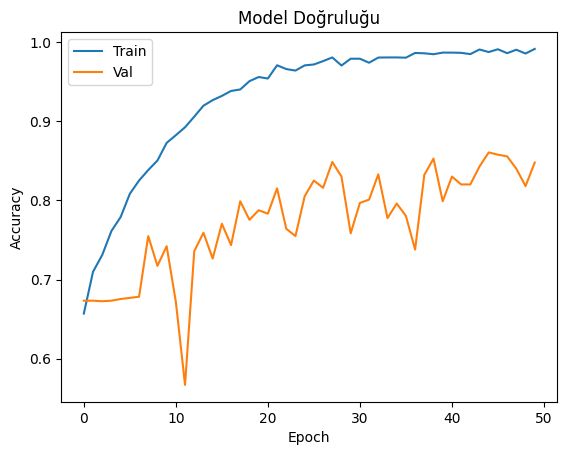

In [20]:
import matplotlib.pyplot as plt

# 'acc' yerine 'accuracy' kullan
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Doğruluğu')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

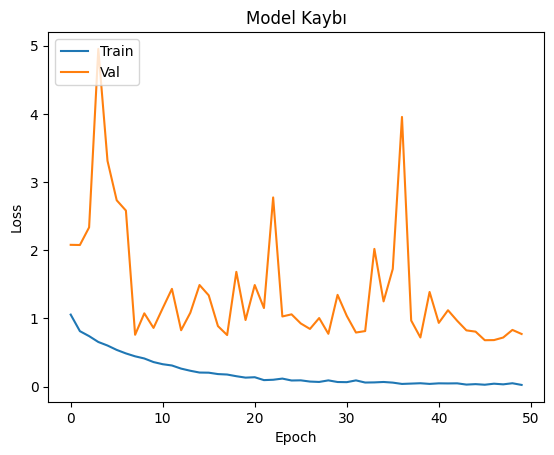

In [21]:
# 'acc' yerine 'accuracy' kullan
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Kaybı')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_data.reset()
predictions = model.predict_generator(test_data,steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred = np.argmax(predictions,axis=1)
# Gerçek etiketleri al (test verisi etiketleri)

C:\Users\Ayfer\AppData\Local\Temp\ipykernel_38276\1826193020.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data,steps=test_data.samples/test_data.batch_size,verbose=1)


1703/1703 [==============================] - 69s 40ms/step


In [25]:
# Karmaşıklık matrisini oluştur
cm = confusion_matrix(name_as_indexes_test, y_pred)

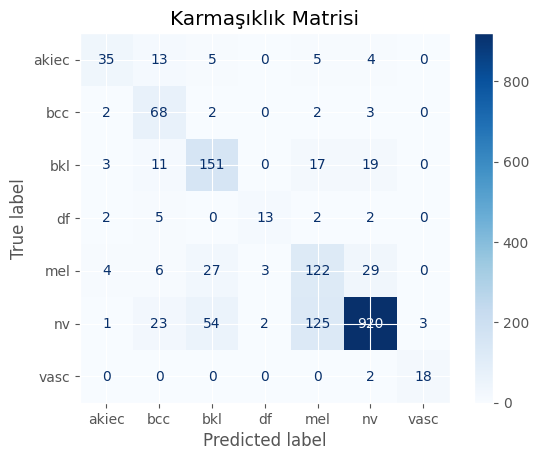

In [28]:
# Karmaşıklık matrisini görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Karmaşıklık Matrisi')
plt.show()

In [29]:
c=np.where(y_pred==name_as_indexes_test)

In [30]:
np.count_nonzero(c)

1326

In [31]:
print("Test Accuracy:",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy: 77.86259541984732


In [32]:
from sklearn.metrics import classification_report
report=classification_report(name_as_indexes_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.56      0.64        62
           1       0.54      0.88      0.67        77
           2       0.63      0.75      0.69       201
           3       0.72      0.54      0.62        24
           4       0.45      0.64      0.53       191
           5       0.94      0.82      0.87      1128
           6       0.86      0.90      0.88        20

    accuracy                           0.78      1703
   macro avg       0.70      0.73      0.70      1703
weighted avg       0.82      0.78      0.79      1703



In [33]:
model.save("yeterSon.h5")

c:\Users\Ayfer\anaconda3\envs\tf-new\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Eğitim doğruluk oranı
train_accuracy = history.history['accuracy'][-1] * 100
val_accuracy = history.history['val_accuracy'][-1] * 100
print(f"Eğitim Doğruluk Oranı: {train_accuracy:.2f}%")
print(f"Doğrulama Doğruluk Oranı: {val_accuracy:.2f}%")

# Test doğruluk oranı
test_data.reset()
predictions = model.predict(test_data, steps=test_data.samples // test_data.batch_size, verbose=1)
y_pred = np.argmax(predictions, axis=1)
test_accuracy = accuracy_score(name_as_indexes_test, y_pred) * 100
print(f"Test Doğruluk Oranı: {test_accuracy:.2f}%")

# F1 Skoru
f1 = f1_score(name_as_indexes_test, y_pred, average='weighted')
print(f"F1 Skoru: {f1:.2f}")

# Detaylı sınıflandırma raporu (isteğe bağlı)
print("\nSınıflandırma Raporu:")
print(classification_report(name_as_indexes_test, y_pred))


Eğitim Doğruluk Oranı: 99.17%
Doğrulama Doğruluk Oranı: 84.80%
1703/1703 [==============================] - 49s 29ms/step
Test Doğruluk Oranı: 77.51%
F1 Skoru: 0.79

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      0.50      0.58        62
           1       0.52      0.88      0.66        77
           2       0.63      0.70      0.67       201
           3       0.81      0.54      0.65        24
           4       0.43      0.63      0.51       191
           5       0.94      0.82      0.88      1128
           6       0.83      0.95      0.88        20

    accuracy                           0.78      1703
   macro avg       0.70      0.72      0.69      1703
weighted avg       0.82      0.78      0.79      1703



In [38]:
total_batches_train = train_data.samples // train_data.batch_size

In [39]:
print("Eğitim yığın boyutu:", train_data.batch_size)
print("Doğrulama yığın boyutu:", val_data.batch_size)
print("Test yığın boyutu:", test_data.batch_size)

Eğitim yığın boyutu: 32
Doğrulama yığın boyutu: 64
Test yığın boyutu: 1


In [40]:
print("Test yığın boyutu:", total_batches_train)

Test yığın boyutu: 215


In [41]:
total_batches_train = train_data.samples // train_data.batch_size  # Tam batch'ler
if train_data.samples % train_data.batch_size != 0:
    total_batches_train += 1  # Kalan örnekler için ekstra batch
print("Toplam batch sayısı (Eğitim):", total_batches_train)

Toplam batch sayısı (Eğitim): 216
